# Deep Learning HW2

Gerald Baulig 0780827 2019/12/02

GitHub: https://github.com/bugerry87/fcnn_scratch

In this assignment we were asked to implement a Convolutional Neural Network (CNN) from scratch.
The CNN has to be demonstrated on two datasets:

1. The MNIST dataset of handwritten digits, and
2. The CIFAR-10 dataset with tiny images of 10 different classes.

# A CNN from Scratch


## The Kernel Convolution


(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 255, 255, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)
(1, 126, 126, 2)


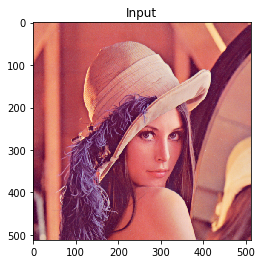

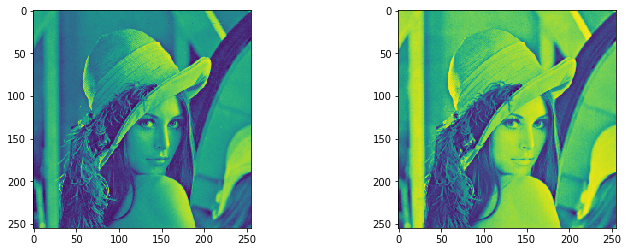

IndexError: index 2 is out of bounds for axis 3 with size 2

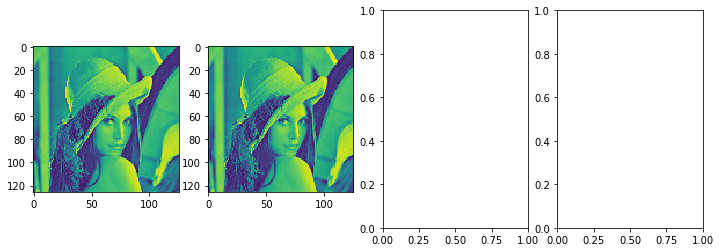

In [149]:
import numpy as np
from mynn import FeedFunc

def shape_nvuc(arr):
    if arr.ndim == 4:
        pass
    elif arr.ndim == 2:
        arr = arr[None,:,:,None]
    elif arr.ndim == 3:
        arr = arr[None,:,:,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)


def conv_indices(xn, kn, kv, ku):
    indices = np.indices((xn, kn, kv, ku))
    indices = np.reshape(indices, (4, xn * kn * kv * ku))
    indices = np.swapaxes(indices, 0, 1)
    return indices


class Conv2D(FeedFunc):
    def __init__(self, stride=(1,1), norm=(), cache=True):
        self.stride = stride
        self.norm = norm
        self.cache = cache
        self.uptodate = False
        pass
    
    def f(self, X, K, backprop=False):
        K, ks = shape_nvuc(K)
        X, xs = shape_nvuc(X)
        stv, stu = self.stride
        
        if backprop:
            indx = conv_indices(xs[0], ks[0], ks[1], ks[2])
            Y = np.zeros((
                int(xs[0]*ks[0]),
                int(np.ceil(xs[1]*stv)),
                int(np.ceil(xs[2]*stu)),
                int(xs[3])
            ))
            print(Y.shape)
        if not self.cache:
            xs[1:3] -= ks[1:3]-1
            indx = conv_indices(xs[0], ks[0], ks[1], ks[2])
            Y = np.zeros((
                int(xs[0]*ks[0]),
                int(np.ceil(xs[1]/stv)),
                int(np.ceil(xs[2]/stu)),
                int(xs[3])
            ))
        elif not self.uptodate:
            xs[1:3] -= ks[1:3]-1
            self.indices = conv_indices(xs[0], ks[0], ks[1], ks[2])
            self.Y = np.zeros((
                int(xs[0]),
                int(np.ceil(xs[1]/stv)),
                int(np.ceil(xs[2]/stu)),
                int(ks[0])
            ))
            Y = self.Y
            indx = self.indices
            self.uptodate = True
        else:
            self.Y *= 0
            Y = self.Y
            indx = self.indices

        for xn, kn, v, u in indx:
            V = xs[1] + v
            U = xs[2] + u
            Y[xn,:,:,kn] = np.sum(X[xn, v:V:stv, u:U:stu] * K[kn,v,u], axis=2)
            print(Y.shape)
        
        for norm in self.norm:
            if norm is 'Merge':
                Y = np.sum(Y, axis=3, keepdims=True)

            elif norm is 'Swap':
                Y = np.swapaxes(Y, 0, 3)

            elif norm is 'AbsMax':
                Y /= np.max(np.abs(Y), axis=(0,1,2))

            elif norm is 'CamReady':
                Y /= np.max(np.abs(Y), axis=(0,1,2)) * 2
                Y += 0.5
        return Y
    
    def dw(self, X, dZ):
        return self.f(X, dZ, True)
    
    def dz(self, dZ, K):
        print(dZ.shape, K.shape)
        return self.f(K, dZ, True)

##test
def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255

    kl1 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    kl1[0,0,:,:] = -1.
    kl1[0,2,:,:] = 1. ##horiz. haar line filter
    kl1[1,:,:,:] = 0
    kl1[1,:,:,0] = 1. ##red filter
    
    np.random.seed(108)
    kl2 = np.random.randn(2,4,4,1)

    conv1 = Conv2D((2,2), ('CamReady',))
    conv2 = Conv2D((2,2), ('CamReady',))
    yl1 = conv1.f(x, kl1)
    yl2 = conv2.f(yl1, kl2)

    ## viz
    plt.imshow(x)
    plt.title('Input')
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,2)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl1[:,:,:,i]))
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,4)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl2[:,:,:,i]))
    plt.show()
test_Conv2D()

## Max Pooling

### Indexing


In [12]:
import numpy as np
import numpy.matlib

def indices(xs, ks, stride=(1,1)):
    kv, ku = ks
    xv, xu = xs
    sv, su = stride
    
    def base(u, k, s):
        u = u+1-k
        K = np.arange(0, k)
        U = np.arange(0, u, s)
        us = U.size
        i = np.reshape(np.tile(K, us), (us, k)) \
            + np.reshape(np.repeat(U, k), (us, k))
        return i
    
    u = base(xu, ku, su)
    if xv == xu and kv == ku:
        v = u.copy()
    else:
        v = base(xv, kv, sv)
    
    shape = (v.shape[0], u.shape[0])
    u = np.matlib.repmat(u, shape[0], kv)
    v = np.repeat(v, ku, axis=1)
    v = np.repeat(v, shape[1], axis=0)
    return v, u, shape

## Test
def test_Indices():
    r = np.reshape(np.arange(5*5), (5,5))
    print("R:\n", r)
    v, u, shape = indices((5,5),(3,3),(2,2))
    r = r[v, u]
    print("U:\n", u)
    print("V:\n", v)
    print("R':\n", r)
test_Indices()

R:
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
U:
 [[0 1 2 0 1 2 0 1 2]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [2 3 4 2 3 4 2 3 4]]
V:
 [[0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [2 2 2 3 3 3 4 4 4]
 [2 2 2 3 3 3 4 4 4]]
R':
 [[ 0  1  2  5  6  7 10 11 12]
 [ 2  3  4  7  8  9 12 13 14]
 [10 11 12 15 16 17 20 21 22]
 [12 13 14 17 18 19 22 23 24]]


(1, 28900, 9, 3)
Shape after pooling: (1, 170, 170, 3)


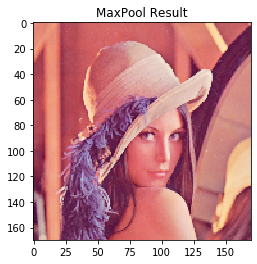

In [63]:
import numpy as np

class MaxPooling():
    def __init__(self,
                 indices,
                 input_func,
                 backprop
                ):
        ''''''
        self.input = input_func
        self.backprop = backprop
        self.v = indices[0]
        self.u = indices[1]
        self.shape = indices[2]
        pass
    
    def pull_forward(self):
        for x in self.input():
            shape = (x.shape[0], self.shape[0], self.shape[1], x.shape[3])
            x = x[:,self.v,self.u,:]
            y = np.max(x, axis=2)
            
            self.x = x
            self.z = np.argmax(x, axis=2)
            self.y = np.reshape(y, shape)
            yield self.y
        pass
    
    def push_backward(self, dZ, lr):
        pass

## Test
def test_MaxPool():
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255
    def gen_Lenna():
         yield x[None]
    
    mp = MaxPooling(
        indices=indices(x.shape[:2],(3,3),(3,3)),
        input_func=gen_Lenna,
        backprop=None
    )
    
    for y in mp.pull_forward():
        print("Shape after pooling:", y.shape)
    
    plt.imshow(y[0])
    plt.title("MaxPool Result")
    plt.show()
    pass

test_MaxPool()

# 1. A CNN for MINIST

## Load n Prepare the MNIST Dataset

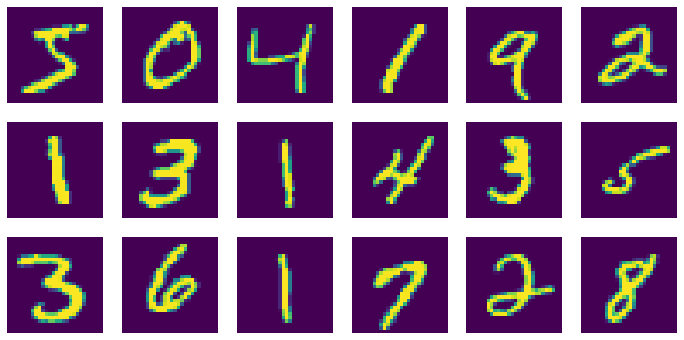

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8]
Input shape: (18, 28, 28, 1)


In [54]:
import numpy as np

def gen_UBYTES_data(filename, epochs=1, batch_size=1, split=1.0, norm=True, preload=False):
    #read header
    with open(filename, 'rb') as fid:
        mag = int.from_bytes(fid.read(4), byteorder='big')
        N = int.from_bytes(fid.read(4), byteorder='big')
        if mag == 2051:
            row = int.from_bytes(fid.read(4), byteorder='big')
            col = int.from_bytes(fid.read(4), byteorder='big')
        else:
            row = 1
            col = 1
        payload = fid.tell()
    
    #split
    if split > 0:
        N0 = 0
        N = int(N * split)
    else:
        N0 = N + int(N * split)
    
    #read payload batch wise
    step = 0
    if preload:
        with open(filename, 'rb') as fid:
            fid.seek(payload)
            batch = fid.read(N*row*col)
        batch = np.frombuffer(batch, dtype=np.uint8)
        if mag == 2051 and norm:
            batch = batch.astype(float) / 255
        batch = np.reshape(batch, (N, row, col, 1))
        for epoch in range(epochs):
            for n in range(N0,N,batch_size):
                trail = batch_size - (n % batch_size)
                step += trail
                yield batch[n:n+trail], epoch, step
    else:
        for epoch in range(epochs):
            for n in range(N0,N,batch_size):
                with open(filename, 'rb') as fid:
                    fid.seek(payload+n)
                    batch = fid.read(batch_size*row*col)
                    batch = np.frombuffer(batch, dtype=np.uint8)
                if mag == 2051 and norm:
                    batch = batch.astype(float) / 255
                trail = batch_size - (n % batch_size)
                step += trail
                batch = np.reshape(batch, (trail, row, col, 1))
                yield batch, epoch, step
    pass

def to_hot_vector(labels, k):
    N = labels.shape[0] if len(labels.shape) else 1
    hot = np.zeros((N, k))
    hot[range(N),labels] = 1
    return hot

def gen_MNIST_data(
    data="train-images.idx3-ubyte",
    labels="train-labels.idx1-ubyte",
    epochs=1,
    batch_size=1,
    split = 1.0,
    norm=True,
    preload=False
):
    gen_data = gen_UBYTES_data(data, epochs, batch_size, split, norm, preload)
    gen_labels = gen_UBYTES_data(labels, epochs, batch_size, split, norm, True)
    for data, label in zip(gen_data, gen_labels):
        X = data[0]
        T = to_hot_vector(np.squeeze(label[0]), 10)
        epoch = data[1]
        step = data[2]
        yield X, T, epoch, step

## test
def test_get_MNIST_data():
    %matplotlib inline
    import matplotlib.pylab as plt
    fig = plt.figure(figsize=(12,6))
    ax = fig.subplots(3,6)
    ax = np.reshape(ax, 6*3)

    ## get one batch and break
    for X, T, _, _ in gen_MNIST_data(
        "train-images.idx3-ubyte",
        "train-labels.idx1-ubyte",
        epochs=1,
        batch_size=6*3,
        norm=False
    ):
        for i, sample in enumerate(X):
            ax[i].set_axis_off()
            ax[i].imshow(np.squeeze(sample))
        break
    plt.show()
    print("Labels:", np.where(np.squeeze(T))[1])
    print("Input shape:", X.shape)
test_get_MNIST_data()

## Configure CNN for MNIST


In [140]:
import numpy as np
from mynn import (
    NeuralNetwork,
    Layer,
    CrossEntropy,
    ArgMaxPooling,
    ReLU
)

def init_params(n, u, v, c, bias=True, init_func=np.random.randn):
    '''Initialize parameters.
    
    Args:
        n: Number of kernels.
        u, v: shape of the kernel.
        c: Number of channels of the kernel
        bias: True, if a bias should be used, otherwise False.
        init_func: Alter the initialization function.
            (default) np.random.randn
    Returns:
        kernels: A 4-dimensional matrix of weights.
        bias: Either 0 or a vector of biases for each node.
    '''
    kernels = init_func(n, v, u, c)
    return kernels, np.zeros(n) if bias else 0

def init_MNIST_cnn(epochs, batch_size):
    '''
    '''
    cnn = NeuralNetwork(
        train_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            epochs, 
            batch_size,
            split=0.8
        ),
        val_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            epochs=1, 
            batch_size=1,
            split=-0.2
        ),
        cost_func=CrossEntropy,
        loss_func=ArgMaxPooling
    )
    
    cnn.In = Layer(
        params=init_params(10,3,3,1),
        feed_func = Conv2D(stride=(2,2), norm=('Merge',)),
        input_func=cnn.gen_input,
        backprop=None,
        act_func = ReLU
    ) #(28-2)/2=13
    
    cnn.Conv1 = Layer(
        params=init_params(1,4,4,10),
        feed_func = Conv2D(stride=(2,2), norm=('Merge',)),
        input_func=cnn.In.pull_forward,
        backprop=cnn.In.push_backward,
        act_func = ReLU
    ) #(13-3)/2=5
    
    cnn.Out = Layer(
        params=init_params(1,5,5,10),
        feed_func = Conv2D(stride=(1,1), norm=('Merge',)),
        input_func=cnn.Conv1.pull_forward,
        backprop=cnn.Conv1.push_backward,
        act_func = ReLU
    ) #5-4=1
    return cnn

cnn = init_MNIST_cnn(1, 1)
print(cnn.__dict__)

{'train_set': <function init_MNIST_cnn.<locals>.<lambda> at 0x000002292FA69730>, 'val_set': <function init_MNIST_cnn.<locals>.<lambda> at 0x000002292FA69C80>, 'cost': <class 'mynn.LossFunctions.CrossEntropy'>, 'loss': <class 'mynn.LossFunctions.ArgMaxPooling'>, 'training': False, 'In': <mynn.Layer.Layer object at 0x000002292F406E80>, 'Conv1': <mynn.Layer.Layer object at 0x000002292F406160>, 'Out': <mynn.Layer.Layer object at 0x000002292F406780>}


## Train CNN for MNIST

In [141]:
from mynn.Tools import train_n_plot

epochs = 1
batch_size = 2
lr = 1e-10
lr_dec = 1e-1
model_name = "mnist_cnn"
ckpts = 1

cnn = init_MNIST_cnn(epochs, batch_size)

train_n_plot(cnn, lr, lr_dec, model_name, ckpts)

(20, 13, 13, 1)
(20, 5, 5, 1)


ValueError: non-broadcastable output operand with shape (1,1,1) doesn't match the broadcast shape (1,1,10)

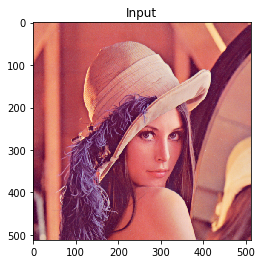

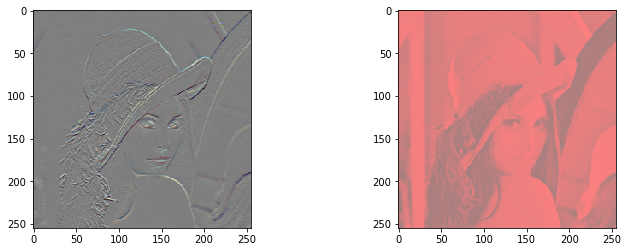

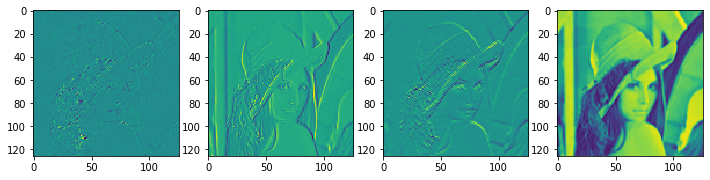

In [72]:


import numpy as np
from PIL import Image
from mynn import FeedFunc

def shape_nvuc(arr):
    if arr.ndim == 4:
        pass
    elif arr.ndim == 2:
        arr = arr[None,:,:,None]
    elif arr.ndim == 3:
        arr = arr[None,:,:,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)

class Conv2D(FeedFunc):
    def __init__(self, stride=(1,1), norm=('Merge'), autoupdate=False):
        self.stride = stride
        self.norm = norm
        self.autoupdate = autoupdate
        self.uptodate = False
        pass
    
    def f(self, X, K):
        X, xs = shape_nvuc(X)
        K, ks = shape_nvuc(K)
        K = np.reshape(K, (ks[0], ks[1]*ks[2], ks[3]))
        
        if self.autoupdate or not self.uptodate:
            self.v, self.u, self.shape = indices(xs[1:3], ks[1:3], self.stride)
            self.xs = xs
            self.ks = ks
            self.uptodate = True
        
        xn = np.tile(np.arange(xs[0]), ks[0])
        kn = np.repeat(np.arange(ks[0]), xs[0])
        X = np.moveaxis(X[:,self.v,self.u,:], 0, -1)
        K = np.moveaxis(K, 0, -1)
        Y = np.sum(X[:, :, :, xn] * K[:,:,kn], axis=1)
        Y = np.reshape(Y, (self.shape[0], self.shape[1], xs[3], xn.size))
        Y = np.moveaxis(Y, -1, 0)
        
        for norm in self.norm:
            if norm is 'Merge':
                Y = np.sum(Y, axis=3, keepdims=True)

            elif norm is 'Swap':
                Y = np.swapaxes(Y, 0, 3)

            elif norm is 'AbsMax':
                Y /= np.max(np.abs(Y), axis=(0,1,2))

            elif norm is 'CamReady':
                Y /= np.max(np.abs(Y), axis=(0,1,2)) * 2
                Y += 0.5
        return Y
    
    def dw(self, X, dZ):
        print(X.shape)
        print(dZ.shape)
        return self.f(X, dZ)
    
    def dz(self, dZ, K):
        return self.f(dZ, K)

##test
def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255

    kl1 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    kl1[0,0,:,:] = -1.
    kl1[0,2,:,:] = 1. ##horiz. haar line filter
    kl1[1,:,:,:] = 0
    kl1[1,:,:,0] = 1. ##red filter
    
    np.random.seed(108)
    kl2 = np.random.randn(2,4,4,1)

    conv1 = Conv2D((2,2), ('Swap','CamReady','Swap'))
    conv2 = Conv2D((2,2), ('Merge','CamReady'))
    yl1 = conv1.f(x, kl1)
    yl2 = conv2.f(yl1, kl2)

    ## viz
    plt.imshow(x)
    plt.title('Input')
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,2)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl1[i]))
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,4)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl2[i]))
    plt.show()
test_Conv2D()